In [2]:
import  os
import  cv2
import  PIL
import  tqdm
import  shutil
import  natsort
import  warnings
import  edge_superres
import  visualization
import  baseline_detection
import  criteria_definition
import  pandas              as      pd
import  numpy               as      np
import  matplotlib.pyplot   as      plt
import  warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

from    scipy.optimize      import curve_fit
from    scipy.signal        import savgol_filter
from    scipy               import ndimage
from    tools               import drop_check
from    PIL                 import Image
from    matplotlib.pyplot   import plot,text, cla, rcParams, text

2025-03-24 20:10:19.290347: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-24 20:10:19.297733: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-24 20:10:19.324475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742843419.367835   17204 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742843419.380330   17204 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 20:10:19.421638: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [ ]:
# import openpyxl

In [3]:
def find_reds(pic):
    red_xs=np.where(pic[:,:,0]!=pic[:,:,1])[1]
    red_ys=np.where(pic[:,:,0]!=pic[:,:,1])[0]
    return(red_xs,red_ys)

def rotate_image(image, angle):
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

def load_files(ad):
    FileName=sorted(os.listdir(ad))
    FileNames=[]
    for i in range(len(FileName)):
        try:
            if FileName[i].split(".")[1]=="tif":
                FileNames=FileNames+[FileName[i]]
        except:
            pass
    FileNames=natsort.natsorted(FileNames)
    return(FileNames)

def slope_measurement(ad):
    pic_slope1=cv2.imread(os.path.join(ad,"slope","1.bmp"))
    pic_slope2=cv2.imread(os.path.join(ad,"slope","2.bmp"))
    red1_xs,red1_ys=find_reds(pic_slope1)
    red2_xs,red2_ys=find_reds(pic_slope2)
    dx=red2_xs-red1_xs
    dy=red2_ys-red1_ys
    gradian=np.arctan((dy)/(dx))
    angle=gradian*180/np.pi
    rotated1=rotate_image(pic_slope1, angle[0])
    return(angle[0],rotated1, red1_xs[0], red1_ys[0], red2_xs[0], red2_ys[0])

def make_folders(ad):
    NewFolder2=os.path.join(ad,"SR_edge")
    try:
        os.makedirs(NewFolder2)
    except:
        shutil.rmtree(NewFolder2)
        os.makedirs(NewFolder2)
    NewFolder3=os.path.join(ad,"SR_result")
    try:
        os.makedirs(NewFolder3)
    except:
        shutil.rmtree(NewFolder3)
        os.makedirs(NewFolder3)


In [4]:
# set variables
ad=r"PFOTS sample with a defect"
fps=1000
cm_on_pixel_ratio= 0.0039062
error_handling_kernel_size=(5,5)
make_folders(ad)

2025-03-24 20:10:31.096412: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
  3%|▎         | 4/119 [00:08<03:21,  1.75s/it]

  4%|▍         | 5/119 [00:09<03:03,  1.61s/it]

100%|██████████| 119/119 [02:17<00:00,  1.16s/it]


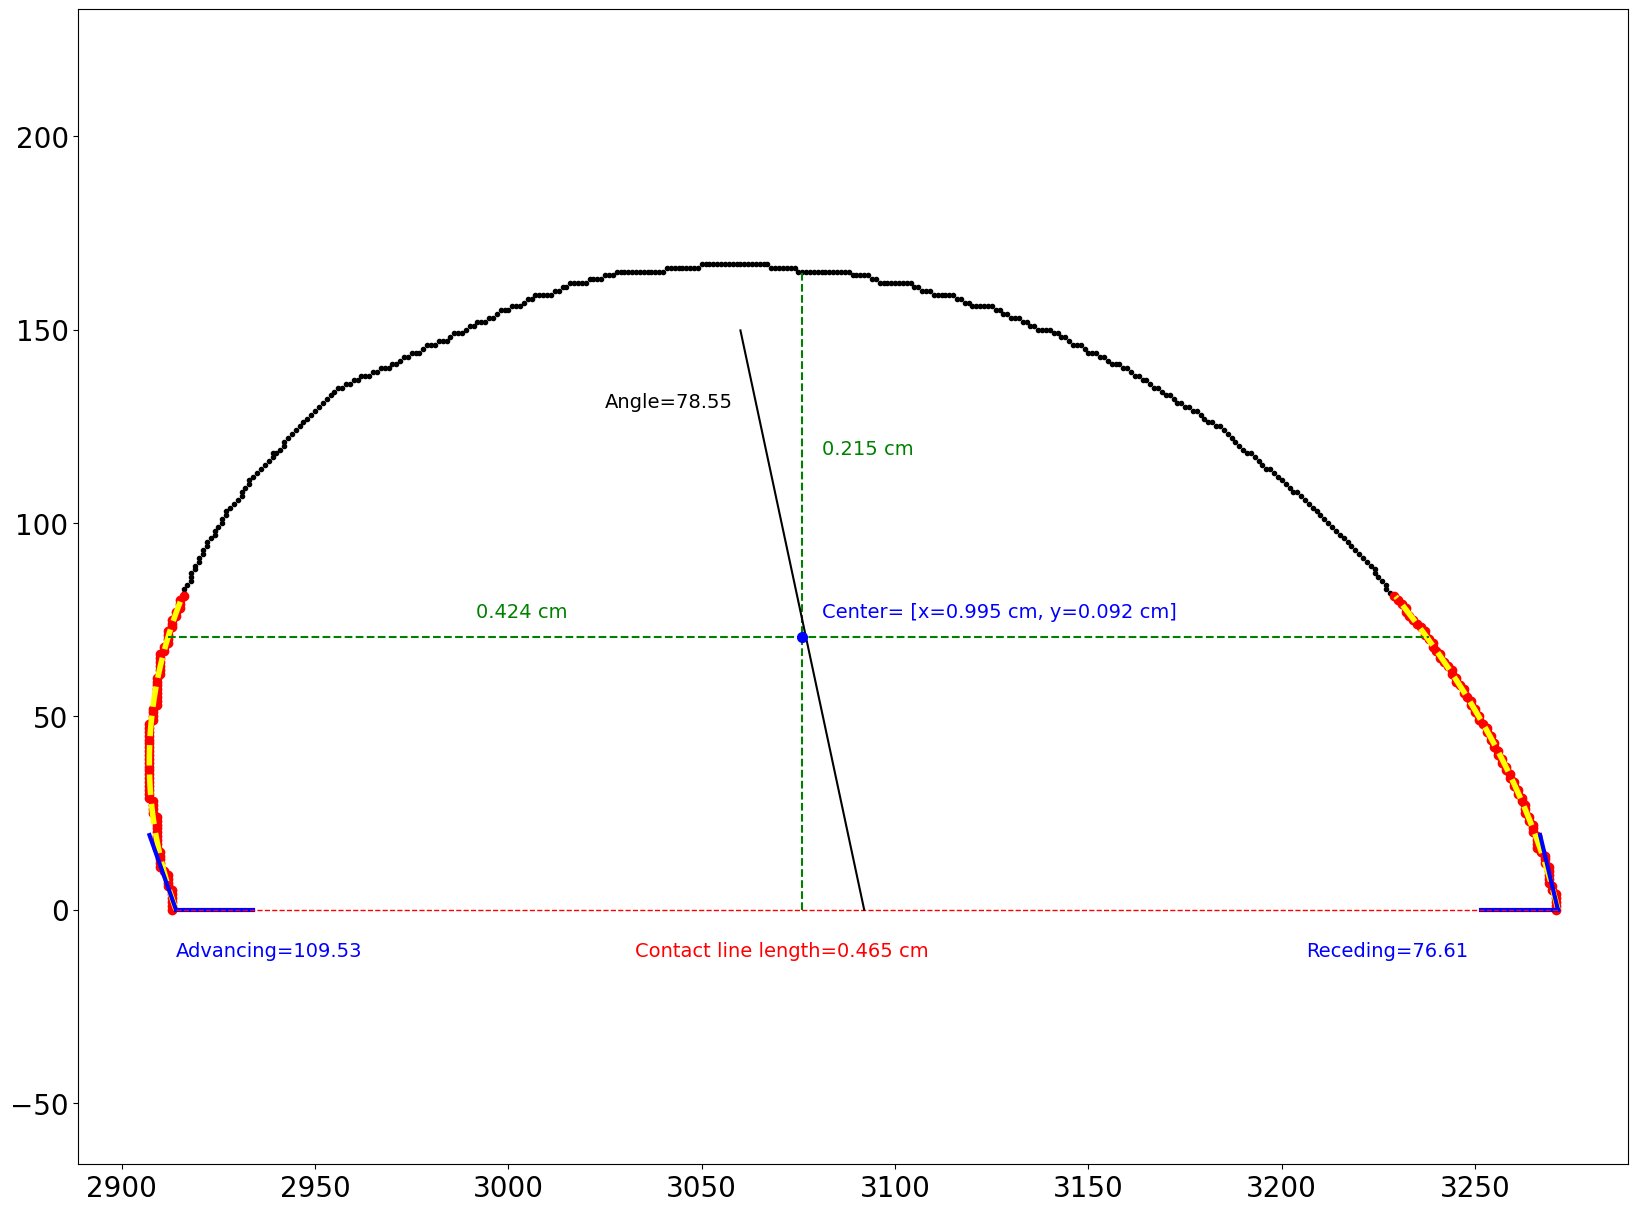

In [5]:
model=edge_superres.model_architecture("SuperRes_weights.h5")
angle, rotated1, red1_xs, red1_ys, red2_xs, red2_ys= slope_measurement(ad)
baseline            =min(find_reds(rotated1)[1])-1
name_files          =load_files(ad)
img_frame           =cv2.imread(os.path.join(ad,name_files[0]))
img_frame_rotated   =rotate_image(img_frame, angle)

adv_list, rec_list, contact_line_length_list, x_center_list, y_center_list, middle_angle_degree_list,processed_number_list=[],[],[],[],[],[],[]
rec_angle_point_list, adv_angle_point_list=[],[]

num_px_ratio=(0.0039062)/cm_on_pixel_ratio
for file_number in tqdm.tqdm(range(1, len(name_files))):

    img_drop=cv2.imread(os.path.join(ad,name_files[file_number]))
    img_drop_rotated=rotate_image(img_drop, angle)

    #drop diff
    diff_img=cv2.absdiff(img_drop_rotated, img_frame_rotated)

    #drop cropping
    BaseL=baseline_detection.Baseline(baseline, middle_drop_height=25,drop_start_height=3*3, object_detection_threshold=40)
    drop_reflection,*dim=BaseL.drop_cropping(diff_img, x_left_margin=30, x_right_margin=60,y_up_margin=10)
    just_drop =diff_img[dim[2]:baseline,dim[0]:dim[1],:]

    #super resolution    
    
    upscaled_image=edge_superres.upscale_image(model, cv2.cvtColor(just_drop.astype('uint8'), cv2.COLOR_BGR2RGB))

    #utilizing morphological transformation to remove noises
    kernel = np.ones(error_handling_kernel_size,np. uint8) 
    upscaled_image=cv2.morphologyEx(np.array(upscaled_image), cv2.MORPH_CLOSE, kernel)

    #keeping just external pixels as droplet curvature
    i_list, j_list =edge_superres.edge_extraction( upscaled_image, thr=40)

    #extracting the desired number of pixels as input of the polynomial fitting 
    left_number_of_pixels=int(150*num_px_ratio)
    right_number_of_pixels=int(65*num_px_ratio)
    i_left, j_left=criteria_definition.advancing_pixel_selection(i_list,j_list, left_number_of_pixels=left_number_of_pixels)
    i_right, j_right=criteria_definition.receding_pixel_selection(i_list,j_list, right_number_of_pixels=right_number_of_pixels)

    #rotation for fitting, it can increase the accuracy to rotate 90 degrees then fit the polynomial
    i_left_rotated,j_left_rotated=j_left,i_left       
    i_right_rotated,j_right_rotated=j_right,i_right   

    left_polynomial_degree=3
    right_polynomial_degree=2
    i_poly_left_rotated, j_poly_left_rotated=criteria_definition.poly_fitting(i_left_rotated,j_left_rotated,polynomial_degree=left_polynomial_degree,line_space=left_number_of_pixels)
    i_poly_right_rotated, j_poly_right_rotated=criteria_definition.poly_fitting(i_right_rotated,j_right_rotated,polynomial_degree=right_polynomial_degree,line_space=right_number_of_pixels)

    right_angle_degree,right_angle_point=criteria_definition.right_angle(i_poly_right_rotated, j_poly_right_rotated,1)
    left_angle_degree,left_angle_point=criteria_definition.left_angle(i_poly_left_rotated, j_poly_left_rotated,1)
    

    if left_angle_degree<=60 :
        left_number_of_pixels=int(60*num_px_ratio)
        left_polynomial_degree=2
    elif 60<left_angle_degree<=105:
        left_number_of_pixels=int(85*num_px_ratio)
        left_polynomial_degree=2
    elif 105<left_angle_degree<=135:
        left_number_of_pixels=int(125*num_px_ratio)  #175
        left_polynomial_degree=3
    elif 135<left_angle_degree:
        left_number_of_pixels=int(145*num_px_ratio) #215
        left_polynomial_degree=4

    if right_angle_degree<=60:
        right_number_of_pixels=int(60*num_px_ratio)
        right_polynomial_degree=2
    elif 60<right_angle_degree<=105:
        right_number_of_pixels=int(85*num_px_ratio)
        right_polynomial_degree=2
    elif 105<right_angle_degree<=135:
        right_number_of_pixels=int(125*num_px_ratio) #175
        right_polynomial_degree=3
    elif 135<right_angle_degree:
        right_number_of_pixels=int(145*num_px_ratio) #215
        right_polynomial_degree=4

    #9. extracting the desired number of pixels as input of the polynomial fitting 
    i_left, j_left=criteria_definition.advancing_pixel_selection(i_list,j_list, left_number_of_pixels=left_number_of_pixels)
    i_right, j_right=criteria_definition.receding_pixel_selection(i_list,j_list, right_number_of_pixels=right_number_of_pixels)

    #10. rotation for fitting, it can increase the accuracy to rotate 90 degrees and then fit the polynomial
    i_left_rotated,j_left_rotated=j_left,i_left       
    i_right_rotated,j_right_rotated=j_right,i_right   
    i_poly_left_rotated, j_poly_left_rotated=criteria_definition.poly_fitting(i_left_rotated,j_left_rotated,polynomial_degree=left_polynomial_degree,line_space=left_number_of_pixels)
    i_poly_right_rotated, j_poly_right_rotated=criteria_definition.poly_fitting(i_right_rotated,j_right_rotated,polynomial_degree=right_polynomial_degree,line_space=right_number_of_pixels)
    j_poly_left=i_poly_left_rotated
    i_poly_left=j_poly_left_rotated
    j_poly_right=i_poly_right_rotated
    i_poly_right=j_poly_right_rotated
    x_cropped=dim[0]

    distance = (x_cropped) * 3
    address=os.path.join(ad,'SR_edge',str(name_files[file_number]))
    adv, rec,rec_angle_point, adv_angle_point, contact_line_length, x_center, y_center, middle_angle_degree=visualization.visualize(address, 
                                                                                                                                   distance+np.array(i_list),j_list,distance+np.array(i_left),j_left,distance+np.array(i_right),j_right,
                                                                                                                                   j_poly_left,distance+np.array(i_poly_left),j_poly_right,distance+np.array(i_poly_right),x_cropped,
                                                                                                                                   distance+np.array(i_poly_left_rotated), j_poly_left_rotated, distance+np.array(i_poly_right_rotated),
                                                                                                                                   j_poly_right_rotated, cm_on_pixel=cm_on_pixel_ratio, middle_line_switch=1)
    processed_number_list.append(int(name_files[file_number].split(".")[0].split("S0001")[-1]))
    adv_list.append(adv)
    rec_list.append(rec)
    adv_angle_point_list.append(adv_angle_point)
    rec_angle_point_list.append(rec_angle_point)
    contact_line_length_list.append(contact_line_length)
    x_center_list.append(x_center)
    y_center_list.append(y_center)
    middle_angle_degree_list.append(middle_angle_degree)

vel=[]
for i in range(len(x_center_list)-1):
    vel=vel+[x_center_list[i+1]-x_center_list[i]]

vel=np.array(vel)*fps


In [6]:
df=pd.DataFrame([processed_number_list, np.arange(0, 1/fps*len(vel), 1/fps), x_center_list, adv_list,rec_list,contact_line_length_list, y_center_list, middle_angle_degree_list, vel]).T
df=df[:-1]

df.columns=['file number', "time (s)", 'x_center (cm)', 'adv (degree)', 'rec (degree)', 'contact_line_length (cm)', 'y_center (cm)', 'middle_angle_degree (degree)', 'velocity (cm/s)']

filter_size=9


df["adv (degree)"]=savgol_filter(df["adv (degree)"], filter_size, 2)
df["rec (degree)"]=savgol_filter(df["rec (degree)"], filter_size, 2)
df["contact_line_length (cm)"]=savgol_filter(df["contact_line_length (cm)"], filter_size, 2)
df["y_center (cm)"]=savgol_filter(df["y_center (cm)"], filter_size, 2)
df["middle_angle_degree (degree)"]=savgol_filter(df["middle_angle_degree (degree)"], filter_size, 2)
df["velocity (cm/s)"]=savgol_filter(df["velocity (cm/s)"], filter_size, 2)
df.to_excel(os.path.join(ad,'SR_result','result.xlsx'))

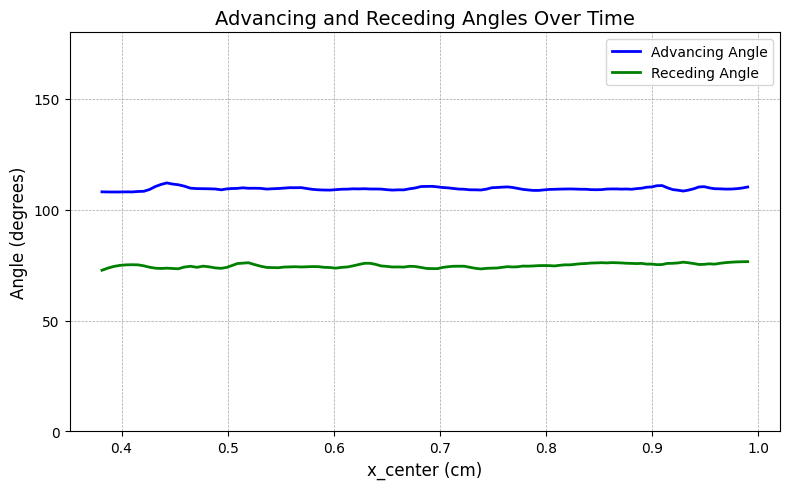

In [7]:
plt.figure(figsize=(8, 5))  # Adjust the size of the figure
plt.plot(df["x_center (cm)"], df["adv (degree)"], label="Advancing Angle", color="blue", linestyle="-", linewidth=2)
plt.plot(df["x_center (cm)"], df["rec (degree)"], label="Receding Angle", color="green", linestyle="-", linewidth=2)

# Adding titles and labels
plt.title("Advancing and Receding Angles Over Time", fontsize=14)
plt.xlabel("x_center (cm)", fontsize=12)
plt.ylabel("Angle (degrees)", fontsize=12)

# Customizing the grid
plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

plt.ylim(0, 180)

# Adding a legend
plt.legend(fontsize=10, loc="best")

# Improving axis ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Display the plot
plt.tight_layout()  # Ensures everything fits well
plt.show()
